In [39]:
import pyabc
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2
from datetime import datetime
import pandas as pd
from arviz import hdi
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix, plot_kde_2d, plot_kde_matrix_for_paper, plot_kde_matrix_for_paper_extended,plot_kde_matrix_for_paper_was
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import emcee

path = '../../results'
output_path = '../../figures'

f = 'extended-prior' # 0.370941 epsilon #bug it is not 1000 reps, it is 100, rerun

In [40]:
history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
history.get_all_populations()[-3:]

,t,population_end_time,samples,epsilon,particles
19,18,2022-03-01 17:30:02.454718,705244,0.400325,344
20,19,2022-03-03 03:06:54.446765,923799,0.385722,326
21,20,2022-03-06 01:52:55.969803,1821705,0.370941,346


In [41]:
history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
samples, weights = history.get_distribution(m=0, t=None)
samples

name,p1_mr,p2_tr,p3_w1,p4_w2,p5_w3
id,,,,,
6537,2.624899e-09,0.003077,1.021535,1.023847,1.024771
6538,2.539720e-09,0.002425,1.023258,1.028901,1.029111
6539,2.488690e-09,0.002408,1.023407,1.027067,1.027720
6540,2.456858e-09,0.005249,1.015722,1.024474,1.025418
6541,2.625163e-09,0.002019,1.023406,1.025797,1.026990
...,...,...,...,...,...
6878,2.560977e-09,0.002175,1.024281,1.027188,1.028053
6879,2.609473e-09,0.002864,1.018774,1.026091,1.026850
6880,2.505511e-09,0.002628,1.023686,1.028004,1.028394


In [48]:
def sample_from_kde(samples, weights, size=50_000, t=None):
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(),weights=weights)
    kdesamples = kde.resample(2*size).T
    kdesamples = pd.DataFrame(data=kdesamples,columns=['mutation rate', 'trisomy rate', '2n+1 fitness', '2n+1* fitness', '2n* fitness'])
    order_criteria = (kdesamples['2n+1 fitness'] < kdesamples['2n+1* fitness']) & (kdesamples['2n+1* fitness'] < kdesamples['2n* fitness'])
    kdesamples = kdesamples[(kdesamples['mutation rate']>1e-9) & (kdesamples['mutation rate']<1e-5) &
              (kdesamples['trisomy rate']>1e-6) & (kdesamples['mutation rate']<1e-2) & order_criteria][:size]

    return kdesamples, kde


In [49]:
import warnings
warnings.filterwarnings('ignore')

def plot(samples, kde, lims=False, logscale = False):              
    c1 = 'Mutation rate, $\mu$'
    c2 = 'Aneuploidy rate, $\delta$'
    c3 ='Fitness of 2n+1, $w_{2n+1}$'
    c4 = 'Fitness of 2n+1*, $w_{2n+1*}$'
    c5 = 'Fitness of 2n*, $w_{2n*}$'
    samples = pd.DataFrame(data=samples.values,columns=[c1, c2, c3, c4, c5])

    if logscale is True:
        for c in samples.columns:
            samples[c] = samples[c].apply(lambda x: np.log(x))
            
    size = len(samples)
    weights = np.full(size,1/size)
#     params_hat = scipy.optimize.minimize(lambda x: -kde.logpdf(x) ,samples.median().values)['x']
    params_hat = scipy.optimize.minimize(lambda x: -kde.logpdf(x) if x[0]>1e-9 and x[0]<1e-5 
                                  and x[1]>1e-6 and x[1]<1e-2 else 100
                                  ,samples.median().values)['x']
#     params_hat = samples.median()
    print(params_hat)
    mutl = (10.0**-9,10.0**-5)
    tril = (10.0**-5,10.0**-2)
    limits = {
        c1 : mutl, 
        c2 : tril,
        c3 : (1,1.1),
        c4 : (1,1.1),
        c5 : (1,1.1)}
    
    if logscale is True:
        limits = {i:(np.log(v[0]),np.log(v[1])) for (i,v) in limits.items()}
        
    if lims is True:
        axes = plot_kde_matrix_for_paper_was(
            samples, weights,numx=1000,limits=limits,numy=1000,refval={c:p for c,p in  zip(samples.columns,params_hat)}
        )
    else:
        axes = plot_kde_matrix_for_paper_extended(
            samples, weights,numx=1000,numy=1000,refval={c:p for c,p in  zip(samples.columns,params_hat)},
            refval_color='red'
        )

[2.47079099e-09 2.69091769e-03 1.02209093e+00 1.05143887e+00
 1.05318280e+00]


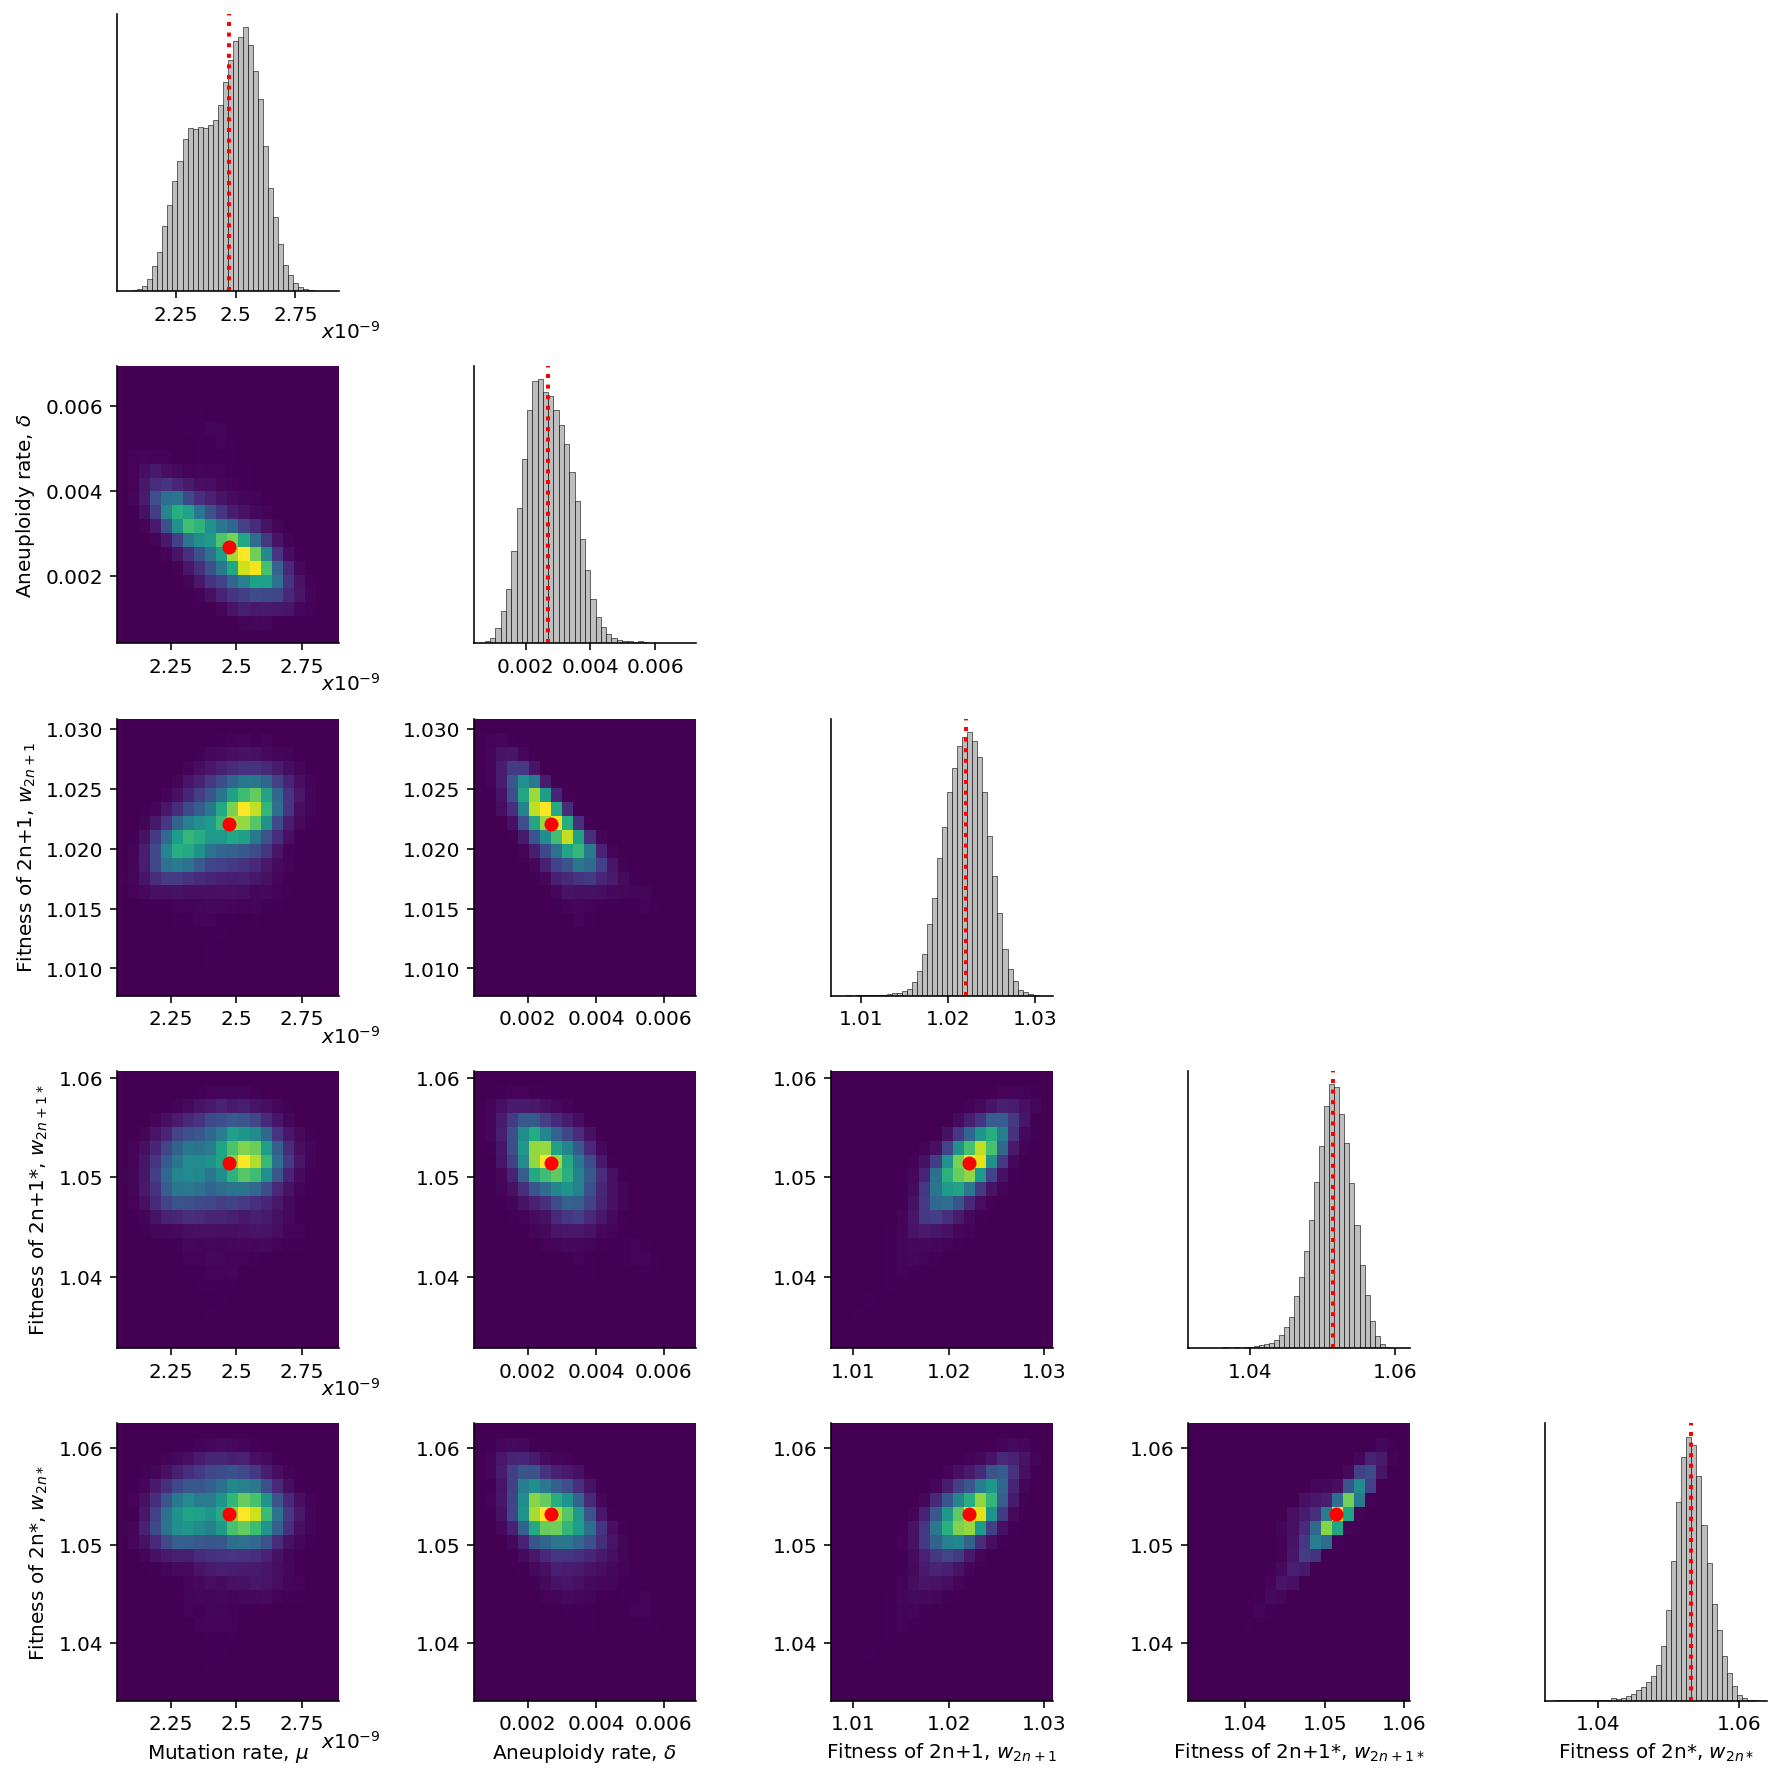

In [50]:
history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, f))
samples, weights = history.get_distribution(m=0, t=18) #t=18, the last t has bad ESS
w2 = samples['p3_w1']*samples['p4_w2']
w3 = samples['p3_w1']*samples['p5_w3']
samples['p4_w2'] = w2
samples['p5_w3'] = w3
samples, kde = sample_from_kde(samples, weights, 50_000)
plot(samples, kde, lims=False, logscale=False)
plt.gcf().savefig(f'{output_path}/posterior-alt.pdf', bbox_inches='tight', dpi=400)